In [1]:
import pandas as pd
import requests
from io import StringIO


def download_and_combine_csv(urls: list) -> pd.DataFrame:
    """
    Download CSV files from provided URLs and combine them row-wise.

    The function ensures compatibility by checking column names or count,
    handling encoding issues, and converting numerical columns to integers.

    Args:
        urls (list): List of URLs pointing to CSV files.

    Returns:
        pd.DataFrame: Combined DataFrame containing data from valid CSV files.
    """
    expected_columns = {'user_prompt', 'url_to_check', 'func_rating', 'custom_rating'}
    combined_df = pd.DataFrame()

    for url in urls:
        try:
            raw_url = url.replace('github.com', 'raw.githubusercontent.com').replace('/blob', '')
            response = requests.get(raw_url)

            if response.status_code == 200:
                try:
                    content = response.content.decode('utf-8')
                except UnicodeDecodeError:
                    content = response.content.decode('latin1')

                df = pd.read_csv(StringIO(content))

                if set(df.columns) == expected_columns:
                    combined_df = pd.concat([combined_df, df], ignore_index=True)
                elif len(df.columns) >= 4:
                    df = df.iloc[:, :4]
                    df.columns = ['user_prompt', 'url_to_check', 'func_rating', 'custom_rating']
                    combined_df = pd.concat([combined_df, df], ignore_index=True)
                else:
                    print(f"Skipping file with insufficient columns: {url}")
            else:
                print(f"Failed to download from {url}")
        except Exception as e:
            print(f"Error processing {url}: {e}")

    if not combined_df.empty:
        combined_df[['func_rating', 'custom_rating']] = combined_df[['func_rating', 'custom_rating']].round().astype(
            int)

    return combined_df


# Example usage:
urls = [
    "https://github.com/vrutika-prajapati/Credibility-Score-for-Articles/blob/main/projects/deliverable%202/Url_validation.csv",
    "https://github.com/Saikumar08-sk/URL-Validation/blob/main/Deliverable.csv",
    "https://github.com/aditya19111/Project-1-Credibility-Score-for-Articles-Sources-References/blob/main/Deliverable_2/Deliverables_rating_comparison%20-%20Sheet1.csv",
    "https://github.com/SAIKUMAR500/algorithums-for-data-science/blob/main/deliverable2/dataset(Sheet1).csv",
    "https://github.com/drashti-sanghani/Credibility_score_articles/blob/main/Project/Deliverable2/user_ratings.csv",
    "https://github.com/anchalrai101/CREDIBILITY-SCORE/blob/main/urltesting_scores.csv",
    "https://github.com/AliSInamdar/CS676-Ali-Inamdar/blob/Project_1_Credibilty_Score/Deliverable_2/Deliverable_2.csv",
    "https://github.com/bhavnaa22/Algorithms-For-Data-Science/blob/main/Deliverable%202/Deliverable2.csv",
    "https://github.com/bhatthardik4/AlgorithmDS/blob/main/Deliverable_2/HardikBhattD2.csv",
    "https://github.com/Rakeshkanche/Algorithms-for-Data-Science/blob/main/queries_urls_ratings.csv",
    "https://github.com/kristinakim-code/Credibility-Check/blob/main/deliverable2.csv",
    "https://github.com/kamaldomandula/Algorithms-of-data-science-Project/blob/main/Project/project1/Deliverable2/deliverable.csv",
    "https://github.com/ChinmayShetye26/Algo-for-DS-delivery2/blob/main/Sample.csv",
    "https://github.com/krishnam229/Project1/blob/main/deliverable2/sample.csv",
    "https://github.com/drona23/Deliverable2/blob/main/output.csv",
    "https://github.com/JoshuaGottlieb/Chatbot-Credibility-Scorer/blob/main/src/deliverable-02/testing/sample.csv",
    "https://github.com/DKethan/searchbot/blob/dev-01/deliverables/samples/url_validation_results.csv"
]

result_df = download_and_combine_csv(urls)
print(result_df)

                                           user_prompt  \
0    I have just been on an international flight, c...   
1          What are the benefits of a vegetarian diet?   
2          What are the benefits of a vegetarian diet?   
3          What are the benefits of a vegetarian diet?   
4    How to improve mental health during stressful ...   
..                                                 ...   
317  Robots recovering dumped explosives from the B...   
318  DOGE staff question 'resign' email as new HR c...   
319  The Elektron Digitone II: A modern classic in ...   
320  The best hearing aids of 2025, reviewed by exp...   
321      Our favorite digital notebooks and smart pens   

                                          url_to_check  func_rating  \
0    https://www.mayoclinic.org/healthy-lifestyle/i...            2   
1    https://www.nhs.uk/live-well/eat-well/how-to-e...            2   
2    https://www.nhs.uk/live-well/eat-well/how-to-e...            2   
3    https://pubmed

In [26]:
# Install the huggingface hub
!pip install huggingface_hub

# Import needed libraries
from IPython import get_ipython
from IPython.display import display
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Dense, Concatenate, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, Concatenate, Flatten
from keras.utils import to_categorical
import matplotlib.pyplot as plt # Import the library here

In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, Concatenate, Flatten

# Define function to create the neural network model
def create_nn_model(vocab_size: int, embedding_dim: int, max_length: int, num_of_dense: int) -> Model:
    """
    Creates a neural network model that processes user prompts using an embedding layer,
    concatenates it with function ratings, and passes through dense layers.

    Args:
        vocab_size (int): Size of the vocabulary for embedding.
        embedding_dim (int): Dimensionality of the embedding layer.
        max_length (int): Maximum length of input sequences.
        num_of_dense (int): Number of dense layers before concatenation.

    Returns:
        Model: A compiled TensorFlow model.
    """
    # Text input (user prompt)
    text_input = Input(shape=(max_length,), name="text_input")
    embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length)(text_input)
    flatten = Flatten()(embedding)

    # Dense layers for text input
    num_neurons = 2**12  # Start with 4096 neurons
    x = flatten
    for _ in range(num_of_dense):
        num_neurons = max(1, int(num_neurons / 2))  # Ensure integer neurons, minimum of 1
        x = Dense(num_neurons, activation='relu')(x)

    # Numeric input (func_rating)
    func_rating_input = Input(shape=(1,), name="func_rating_input")
    y = Dense(32, activation='relu')(func_rating_input)

    # Concatenate both paths
    concatenated = Concatenate()([x, y])
    # output = Dense(1, activation='linear', name="output")(concatenated)
    output = Dense(6, activation='softmax', name="output")(concatenated)

    # Define and compile the model
    model = Model(inputs=[text_input, func_rating_input], outputs=output)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [15]:
df = result_df

df.tail()

,user_prompt,url_to_check,func_rating,custom_rating
317,Robots recovering dumped explosives from the B...,https://hakaimagazine.com/features/the-big-bal...,4,4
318,DOGE staff question 'resign' email as new HR c...,https://www.desmoinesregister.com/story/news/l...,3,3
319,The Elektron Digitone II: A modern classic in ...,https://www.wired.com/review/elektron-digitone...,4,4
320,"The best hearing aids of 2025, reviewed by exp...",https://www.cnet.com/health/medical/best-over-...,3,3
321,Our favorite digital notebooks and smart pens,https://www.zdnet.com/article/best-smart-noteb...,3,3


In [5]:
df["custom_rating"].unique()

array([3, 4, 2, 5, 1, 0])

In [16]:
df.shape

(322, 4)

In [17]:
# Tokenize and prepare data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df["user_prompt"])
vocab_size = len(tokenizer.word_index) + 1
max_length = max([len(x.split()) for x in df["user_prompt"]])
embedding_dim = 16

# Convert text data into sequences
X_text = tokenizer.texts_to_sequences(df["user_prompt"])
X_text = pad_sequences(X_text, maxlen=max_length, padding='post')
print(X_text.shape)

# Numeric input
X_func_rating = np.array(df["func_rating"]).reshape(-1, 1)
print(X_func_rating.shape)

# Target variable
y = np.array(df["custom_rating"]).reshape(-1, 1)
print(y.shape)

(322, 26)
(322, 1)
(322, 1)


In [18]:
df["custom_rating"].unique()

array([3, 4, 2, 5, 1, 0])

In [19]:
from keras.utils import to_categorical

# Assuming y is your array of class labels shaped as (20, 1)
# Convert labels to one-hot encoding
y_one_hot = to_categorical(y)

# Check the new shape of y_one_hot
print(y_one_hot.shape)

(322, 6)


In [20]:
# Create the model
num_of_dense_layers = 3  # Example: 2 dense layers before concatenation
model = create_nn_model(vocab_size, embedding_dim, max_length, num_of_dense_layers)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [33]:
%%time

# Train the model and capture the history
history = model.fit(
    {"text_input": X_text, "func_rating_input": X_func_rating},
    y_one_hot,
    epochs=80,
    batch_size=2,
    validation_split=0.1,
    verbose=2
)

Epoch 1/80
145/145 - 11s - 77ms/step - accuracy: 0.5329 - loss: 1.3818 - val_accuracy: 0.4545 - val_loss: 1.4109
Epoch 2/80
145/145 - 11s - 77ms/step - accuracy: 0.5640 - loss: 1.1299 - val_accuracy: 0.3939 - val_loss: 1.3131
Epoch 3/80
145/145 - 8s - 56ms/step - accuracy: 0.6609 - loss: 0.9190 - val_accuracy: 0.3939 - val_loss: 1.4660
Epoch 4/80
145/145 - 10s - 71ms/step - accuracy: 0.7578 - loss: 0.6711 - val_accuracy: 0.2727 - val_loss: 1.5299
Epoch 5/80
145/145 - 9s - 59ms/step - accuracy: 0.8443 - loss: 0.4936 - val_accuracy: 0.3030 - val_loss: 1.6088
Epoch 6/80
145/145 - 10s - 71ms/step - accuracy: 0.8754 - loss: 0.3544 - val_accuracy: 0.2121 - val_loss: 1.9067
Epoch 7/80
145/145 - 9s - 65ms/step - accuracy: 0.8824 - loss: 0.2951 - val_accuracy: 0.2424 - val_loss: 2.3207
Epoch 8/80
145/145 - 10s - 71ms/step - accuracy: 0.8962 - loss: 0.2818 - val_accuracy: 0.2727 - val_loss: 1.9069
Epoch 9/80
145/145 - 11s - 74ms/step - accuracy: 0.9100 - loss: 0.2343 - val_accuracy: 0.3333 - val

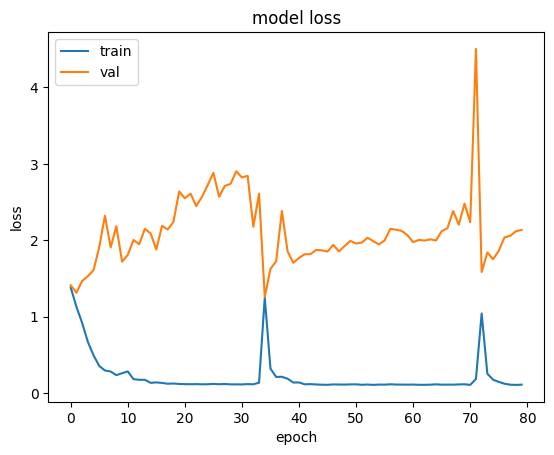

In [35]:
# Plot error
import matplotlib.pyplot as plt

plt.plot(history.history['loss']) # we now use history.history
plt.plot(history.history['val_loss']) # we now use history.history
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [36]:
# Display the model summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ text_input (InputLayer)   │ (None, 26)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 26, 16)         │         14,528 │ text_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 416)            │              0 │ embedding_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 2048)           │        854,016 │ flatten_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 1024)           │      2,098,176 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ func_rating_input         │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 512)            │        524,800 │ dense_5[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 32)             │             64 │ func_rating_input[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 544)            │              0 │ dense_6[0][0],         │
│ (Concatenate)             │                        │                │ dense_7[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output (Dense)            │ (None, 6)              │          3,270 │ concatenate_1[0][0]    │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 10,484,564 (40.00 MB)

 Trainable params: 3,494,854 (13.33 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,989,710 (26.66 MB)

In [ ]:
from huggingface_hub import HfApi, login

hf_username = "krishnam229"  # Replace with your Hugging Face username
repo_name = "Deliverable3"  # Change this as needed
repo_id = f"{hf_username}/{repo_name}"

api = HfApi()

# Create the repository
api.create_repo(repo_id=repo_id, exist_ok=True)  # exist_ok=True prevents errors if the repo already exists

print(f"Repository created: https://huggingface.co/{repo_id}")

Repository created: https://huggingface.co/krishnam229/Deliverable3


In [45]:

import pickle
import os
from huggingface_hub import HfApi
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer

# Define save directory
model_dir = "./saved_model"
os.makedirs(model_dir, exist_ok=True)

# Save the model
model_path = os.path.join(model_dir, "model.keras")
model.save(model_path)

# Save the tokenizer as a pickle file
tokenizer_path = os.path.join(model_dir, "tokenizer.pkl")
with open(tokenizer_path, "wb") as f:
    pickle.dump(tokenizer, f)

# Upload model and tokenizer to Hugging Face
repo_id = f"{hf_username}/{repo_name}"  # Change as needed
api = HfApi()

api.upload_file(path_or_fileobj=model_path, path_in_repo="model.keras", repo_id=repo_id)
api.upload_file(path_or_fileobj=tokenizer_path, path_in_repo="tokenizer.pkl", repo_id=repo_id)

print(f"Model and tokenizer successfully pushed to: https://huggingface.co/{repo_id}")

model.keras:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

tokenizer.pkl:   0%|          | 0.00/33.5k [00:00<?, ?B/s]

Model and tokenizer successfully pushed to: https://huggingface.co/krishnam229/Deliverable3


In [46]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from huggingface_hub import hf_hub_download

# Set Keras backend to JAX (Optional, only needed if you want to experiment with JAX backend)
os.environ["KERAS_BACKEND"] = "jax"

# Define repo ID and model filename
# repo_id = "eagle0504/my-tf-nn-model" # we already defined it above
filename = "model.keras"  # Ensure this matches what was uploaded

# Download the model
model_path = hf_hub_download(repo_id=repo_id, filename=filename)

# Load the Keras model
new_model = keras.models.load_model(model_path)

print("Model loaded successfully!")

model.keras:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Model loaded successfully!


In [40]:
new_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ text_input (InputLayer)   │ (None, 26)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 26, 16)         │         14,528 │ text_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 416)            │              0 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 2048)           │        854,016 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 1024)           │      2,098,176 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ func_rating_input         │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 512)            │        524,800 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 32)             │             64 │ func_rating_input[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 544)            │              0 │ dense_2[0][0],         │
│                           │                        │                │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output (Dense)            │ (None, 6)              │          3,270 │ concatenate[0][0]      │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 10,484,564 (40.00 MB)

 Trainable params: 3,494,854 (13.33 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,989,710 (26.66 MB)

In [47]:
import pickle
from huggingface_hub import hf_hub_download
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Define repo details
# repo_id = "eagle0504/my-tf-nn-model" # we already defined above

# Download model
# model_path = hf_hub_download(repo_id=repo_id, filename="model.keras")
# new_model = keras.models.load_model(model_path)

# Download tokenizer
tokenizer_path = hf_hub_download(repo_id=repo_id, filename="tokenizer.pkl")

# Load the tokenizer
with open(tokenizer_path, "rb") as f:
    tokenizer = pickle.load(f)

print("Model and tokenizer loaded successfully!")

# Sample test data
test_texts = [
    "How to improve focus and concentration?",
    "What are the side effects of lack of sleep?",
]

# Preprocess test data using the loaded tokenizer
max_length = model.input_shape[0][1]  # Get max_length from model input shape
X_text_test = tokenizer.texts_to_sequences(test_texts)
X_text_test = pad_sequences(X_text_test, maxlen=max_length, padding='post')

# Dummy numeric input (func_rating)
X_func_test = np.array([5, 4]).reshape(-1, 1)

# Make predictions
predictions = new_model.predict({"text_input": X_text_test, "func_rating_input": X_func_test})

# Display results
for i, text in enumerate(test_texts):
    print(f"Prompt: {text}")
    print(f"Predicted Rating: {predictions[i][0]:.2f}")
    print("-" * 50)

tokenizer.pkl:   0%|          | 0.00/33.5k [00:00<?, ?B/s]

Model and tokenizer loaded successfully!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
Prompt: How to improve focus and concentration?
Predicted Rating: 0.00
--------------------------------------------------
Prompt: What are the side effects of lack of sleep?
Predicted Rating: 0.00
--------------------------------------------------
